In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

# Standardize the features
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

# print out
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train[:2])
print(X_train_norm[:2])
print(y_train[:2])

(150, 4)
(150,)
(100, 4)
(100,)
[[5.1 3.4 1.5 0.2]
 [5.5 3.5 1.3 0.2]]
[[ 0.8389246  -0.02752244 -0.99590442 -1.65848156]
 [ 1.04279449  0.02344504 -1.09783936 -1.65848156]]
[0 0]


In [5]:
# Convert the standardized features and the labels into torch tensors
X_train_norm_ts = torch.from_numpy(X_train_norm).float()
y_train_ts = torch.from_numpy(y_train)

print(X_train_norm_ts.shape)
print(y_train_ts.shape)
print(y_train_ts.dtype)
print(X_train_norm_ts[:2])
print(y_train_ts[:2])

# Create a PyTorch Dataset
train_ds = TensorDataset(X_train_norm_ts, y_train_ts)

torch.Size([100, 4])
torch.Size([100])
torch.int64
tensor([[ 0.8389, -0.0275, -0.9959, -1.6585],
        [ 1.0428,  0.0234, -1.0978, -1.6585]])
tensor([0, 0])


In [7]:
# Assuming X_test_norm is the standardized features of the test set
# and y_test is the actual labels for the test set
X_valid_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_valid_norm_ts = torch.from_numpy(X_valid_norm).float()
y_valid_ts = torch.from_numpy(y_test)

In [8]:
# Define the model
import torch
import torch.nn as nn

class ClassifierModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassifierModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

In [9]:
# Assuming X_train_norm.shape[1] is the input size for the dataset
input_size = X_train_norm.shape[1]
print(input_size)
hidden_size = 16
output_size = 3

# Initialize the model
model = ClassifierModel(input_size, hidden_size, output_size)

4


In [10]:
def accuracy_sum_multiclass_fn(y_pred, y):
    is_correct = (torch.argmax(y_pred, dim=1) == y).float()
    accuracy = is_correct.sum()
    return accuracy

In [11]:
def fit_model(model: torch.nn.Module,
                train_ds: TensorDataset,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                x_valid: torch.Tensor = None,
                y_valid: torch.Tensor = None,
                accuracy_fn = None,
                num_epochs = 100,
                batch_size = 32,
                seed = 1,
                transform_pred = None,
                device: torch.device = "cpu"):
    # variables
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs    
    torch.manual_seed(seed)
    train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    n_train = len(train_dl.dataset)
    # set model to device
    model.to(device)
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        # mini-batch training
        for x_batch, y_batch in train_dl:
            # Send data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            if transform_pred:
                y_pred = transform_pred(y_pred)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)

            # Do backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            accuracy_batch = 0
            if accuracy_fn:
                accuracy_batch = accuracy_fn(y_pred, y_batch)
            loss_hist_train[epoch] += loss.item()
            accuracy_hist_train[epoch] += accuracy_batch

        # Compute store loss and accuracy as percent
        loss_hist_train[epoch] /= n_train
        accuracy_hist_train[epoch] /= n_train
        
        if x_valid is not None and y_valid is not None:
            n_valid = len(y_valid)
            # set model to training mode
            model.eval()
            with torch.no_grad():
                x_valid, y_valid = x_valid.to(device), y_valid.to(device)
                y_valid_pred = model(x_valid)
                if transform_pred:
                    y_valid_pred = transform_pred(y_valid_pred)
                loss = loss_fn(y_valid_pred, y_valid)

                accuracy_valid = 0
                if accuracy_fn:
                    accuracy_valid = accuracy_fn(y_valid_pred, y_valid)
                loss_hist_valid[epoch] = loss.item()
                accuracy_hist_valid[epoch] = accuracy_valid / n_valid
                    
        # Print out
        if epoch % 10 == 0:
            if x_valid is not None and y_valid is not None:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}% | Val loss: {loss_hist_valid[epoch]:.5f} | Val accuracy: {accuracy_hist_valid[epoch]:.2f}%")
            else:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}%")

    # Return result    
    return (loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [12]:
# Assuming model is already defined and train_dl is your DataLoader
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = fit_model(model, 
                                                                                       train_dataset, 
                                                                                       loss_fn, 
                                                                                       optimizer, 
                                                                                       x_valid=X_valid_norm_ts,
                                                                                       y_valid=y_valid_ts,
                                                                                       num_epochs = 200,
                                                                                       batch_size=2,
                                                                                       accuracy_fn=accuracy_sum_multiclass_fn)

Train loss: 0.54880 | Train accuracy: 0.36% | Val loss: 1.10047 | Val accuracy: 0.28%
Train loss: 0.42975 | Train accuracy: 0.70% | Val loss: 0.85961 | Val accuracy: 0.64%
Train loss: 0.29541 | Train accuracy: 0.81% | Val loss: 0.59321 | Val accuracy: 0.78%
Train loss: 0.22455 | Train accuracy: 0.87% | Val loss: 0.44795 | Val accuracy: 0.82%
Train loss: 0.18195 | Train accuracy: 0.91% | Val loss: 0.36145 | Val accuracy: 0.94%
Train loss: 0.15221 | Train accuracy: 0.92% | Val loss: 0.29874 | Val accuracy: 0.96%
Train loss: 0.13019 | Train accuracy: 0.92% | Val loss: 0.25009 | Val accuracy: 0.96%
Train loss: 0.11318 | Train accuracy: 0.96% | Val loss: 0.21039 | Val accuracy: 0.98%
Train loss: 0.09998 | Train accuracy: 0.96% | Val loss: 0.18316 | Val accuracy: 0.98%
Train loss: 0.09030 | Train accuracy: 0.96% | Val loss: 0.16219 | Val accuracy: 0.98%
Train loss: 0.08319 | Train accuracy: 0.95% | Val loss: 0.14665 | Val accuracy: 0.98%
Train loss: 0.07600 | Train accuracy: 0.95% | Val loss

In [15]:
print(loss_hist)
print(accuracy_hist)

[0.8135492086410523, 0.7588628667593003, 0.7111397576332092, 0.6719258260726929, 0.6383331894874573, 0.6059715110063553, 0.5801383525133132, 0.556642844080925, 0.5389100930094719, 0.5192554783821106, 0.5008705133199691, 0.48517249524593353, 0.47222017765045166, 0.45996266305446626, 0.4484421718120575, 0.4353017032146454, 0.4254321849346161, 0.4161274790763855, 0.40693900793790816, 0.39803446307778356, 0.38952188968658447, 0.3826409314572811, 0.375131576359272, 0.36658162221312524, 0.3594175365567207, 0.3528972569108009, 0.34636581137776373, 0.3407533848285675, 0.3335136756300926, 0.3290796579420567, 0.32369045943021774, 0.31662929102778437, 0.31307944007217886, 0.308315609395504, 0.3042901631444693, 0.2969411316514015, 0.29248501524329185, 0.28839082226157187, 0.28372003115713595, 0.2790605357289314, 0.2753743738681078, 0.27112924538552763, 0.26696550376713274, 0.2626830527931452, 0.25945766769349576, 0.25553938627243045, 0.2521798450499773, 0.24891563184559345, 0.24452513486146926, 0.

In [15]:
def plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid = None, accuracy_hist_valid = None, loss_title='Loss', accuracy_title='Accuracy'):
    # Visualization setup
    loss_legend = ['Train Loss']
    acc_legend = ['Train Acc']
    fig = plt.figure(figsize=(16, 4))

    # Plot for training loss
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_hist_train, lw=4)
    if loss_hist_valid:
        ax.plot(loss_hist_valid, lw=4)
        loss_legend.append('Valid Loss')
    ax.legend(loss_legend)
    ax.set_title(loss_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Plot for training accuracy
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracy_hist_train, lw=4)
    if accuracy_hist_valid:
        ax.plot(accuracy_hist_valid, lw=4)
        acc_legend.append('Valid Acc')
    ax.legend(acc_legend)
    ax.set_title(accuracy_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

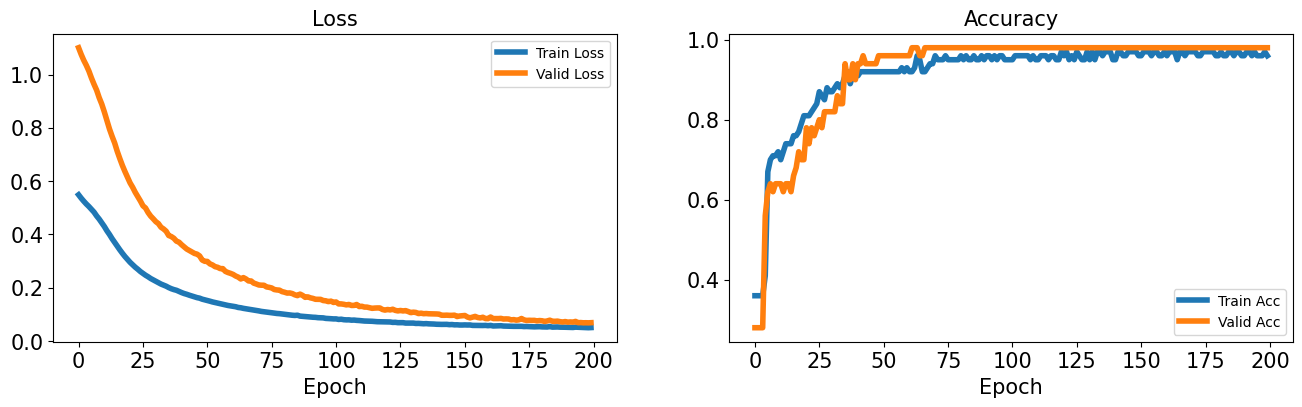

In [16]:
plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [17]:
def evaluate_model(model: torch.nn.Module,
                    x_test: torch.Tensor,
                    y_test: torch.Tensor,
                    score_fn,
                    transform_pred = None,
                    device: torch.device = "cpu"):
    # set to device
    model.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    # logic
    y_pred = model(x_test)
    if transform_pred:
        y_pred = transform_pred(y_pred)
    score = score_fn(y_pred, y_test)
    score = score / len(y_test)
    # result
    return score

In [19]:
score = evaluate_model(model, X_valid_norm_ts, y_valid_ts, accuracy_sum_multiclass_fn)
print(score)

tensor(0.9800)


In [24]:
def predict_multiclass_fn(y_pred):
    return torch.argmax(y_pred, dim=1)

In [26]:
# predict
y_pred = model(X_valid_norm_ts[:2])
print(y_pred)
y_pred = predict_multiclass_fn(y_pred)
print(y_pred)
print(y_valid_ts[:2])

tensor([[ 8.7687,  2.0353, -7.6429],
        [-0.2323,  2.6067, -4.7537]], grad_fn=<AddmmBackward0>)
tensor([0, 1])
tensor([0, 1])


In [26]:
# Saving the trained model
path = 'models/iris_classifier_v1.pt'
torch.save(model, path)

ClassifierModel(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [27]:
# Reloading the trained model
model = torch.load(path)
model.eval()  # Set the model to evaluation mode

ClassifierModel(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [28]:
path = 'models/iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [30]:
model_new = ClassifierModel(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

In [31]:
# Predict
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800
